<a href="https://colab.research.google.com/github/MoghazyCoder/Deep-Lab/blob/master/Street_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image

import cv2

#%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the PASCAL VOC dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

In [0]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

In [0]:
def create_ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.
  Returns:
    A colormap for visualizing segmentation results.
  """
  arr = np.ones((151,3)) * 255
  arr[7] = [0,255,0]
  return arr

In [0]:
def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(30, 30))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])
    
    seg_image = create_ade20k_label_colormap()[seg_map].astype(np.uint8)

    dst = Image.blend(image, Image.fromarray(seg_image), 0.5)
    plt.imshow(dst)
    plt.axis('off')
    plt.title('segmentation overlay')


## Select a pretrained model
We have trained the DeepLab model using various backbone networks. Select one from the MODEL_NAME list.

In [5]:
model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, "deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz")
print('downloading model, this might take a while...')
urllib.request.urlretrieve('http://download.tensorflow.org/models/deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz',
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [6]:
download_path
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that this colab uses single scale inference for fast computation,
so the results may slightly differ from the visualizations in the
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md) file,
which uses multi-scale and left-right flipped inputs.

In [0]:
from PIL import Image

import cv2

def run_visualization(url):
    """Inferences DeepLab model and visualizes result."""
    original_im = Image.open(url)

    resized_im, seg_map = MODEL.run(original_im)
    vis_segmentation(resized_im, seg_map)

def run_visualization_vid(frame_idx, frame):
    """Inferences DeepLab model and visualizes result."""

    resized_im, seg_map = MODEL.run(Image.fromarray(frame))
    vis_segmentation_vid(frame_idx, resized_im, seg_map)

In [0]:
img2="/content/112.jpg"

14.456141233444214


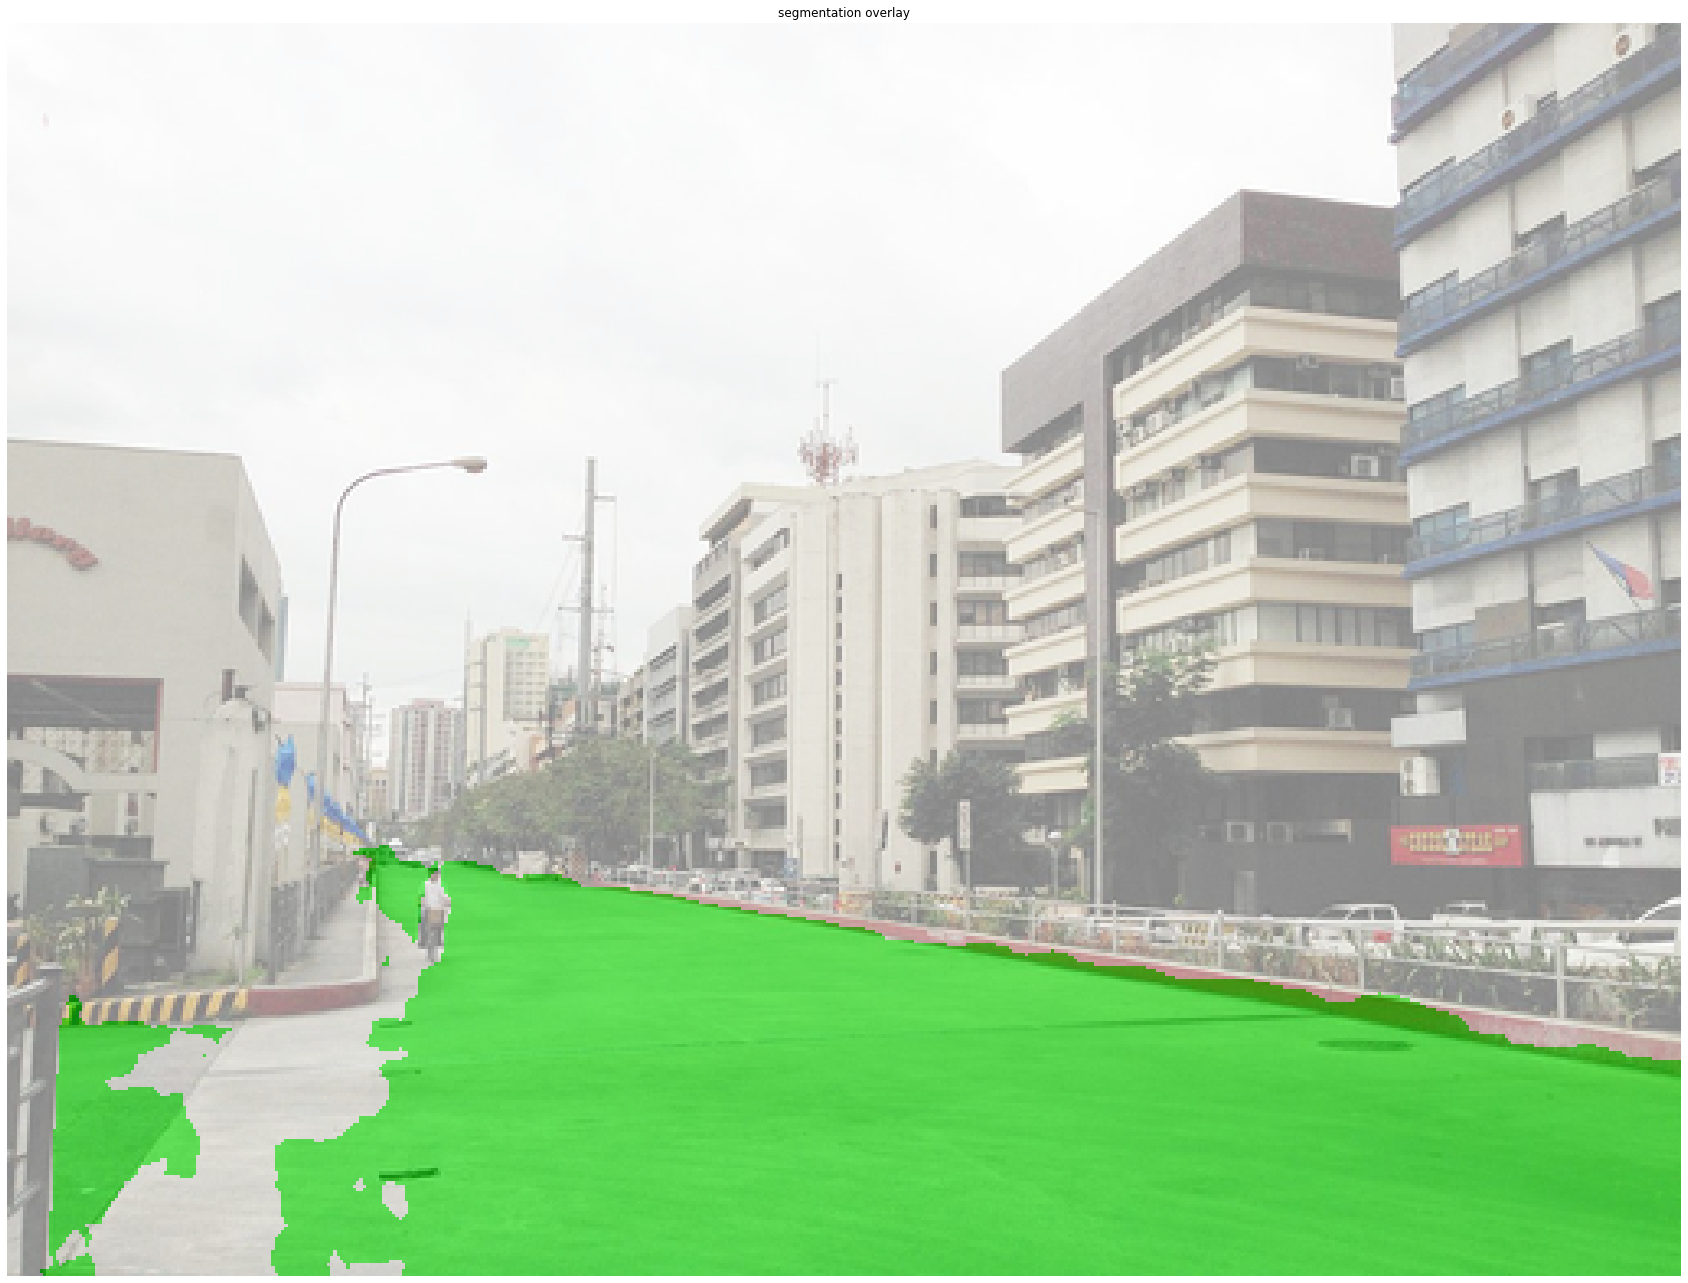

In [9]:
import time

t = time.time()
run_visualization(img2)

print(time.time() - t)

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def video_capture(input_path: str):
    """
    This function is used for producing the video frames and storing them into a specific path
    """
    frame_idx = 0
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            frame_idx += 1
            run_visualization_vid(frame_idx, frame)
            
            
cap = cv2.VideoCapture('/data/data/video.mp4')
video_capture(cap)

Error opening video stream or file


In [0]:
video_url="/data/data/video.mp4"

## What's next

* Learn about [Cloud TPUs](https://cloud.google.com/tpu/docs) that Google designed and optimized specifically to speed up and scale up ML workloads for training and inference and to enable ML engineers and researchers to iterate more quickly.
* Explore the range of [Cloud TPU tutorials and Colabs](https://cloud.google.com/tpu/docs/tutorials) to find other examples that can be used when implementing your ML project.
* For more information on running the DeepLab model on Cloud TPUs, see the [DeepLab tutorial](https://cloud.google.com/tpu/docs/tutorials/deeplab).
